In [43]:
# import from baseline.py all the functions and variables except the main function
from baseline import (
    nltk_preprocess,
    load_dataset,
    get_split,
    get_X_y_split,
    get_pipeline,
    evaluate_with_J_threshold,
    get_thresholded_predictions,
)

import numpy as np
import pandas as pd
import re
import random
import optuna
from imblearn.under_sampling import RandomUnderSampler
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, fbeta_score, roc_auc_score, \
    average_precision_score, roc_curve
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Reproducibility
random.seed(42)
np.random.seed(42)

In [6]:
from pathlib import Path
import nltk

NLTK_DIR = Path("../data/nltk_data")
NLTK_DIR.mkdir(parents=True, exist_ok=True)
nltk.data.path.append(str(NLTK_DIR))

In [9]:
# load the full model from results/baseline_lr_results.txt
with open("./results/baseline_lr_results.txt", "r") as f:
    print(f.read())


Best hyperparameters: {'solver': 'newton-cg', 'C': 9.104166106506888}
Best J statistic on dev set: 0.28030303030303033 at threshold 0.5371366726029445

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        44
           1       0.45      0.42      0.43        12

    accuracy                           0.77        56
   macro avg       0.65      0.64      0.64        56
weighted avg       0.76      0.77      0.76        56



In [16]:
best_params = {'solver': 'newton-cg', 'C': 9.104166106506888}
best_t = 0.5371366726029445
best_j = 0.28030303030303033

df = load_dataset()

# get only train part of the dataset
df_train = get_split(df, "train")
# get only dev part of the dataset
df_dev = get_split(df, "dev")

X_train, y_depr_train, X_dev, y_depr_dev = get_X_y_split(df_train, df_dev)

pipeline = get_pipeline(best_params)
pipeline.fit(X_train, y_depr_train)

y_proba = pipeline.predict_proba(X_dev)[:, 1]
y_depr_pred = get_thresholded_predictions(y_proba, best_t)

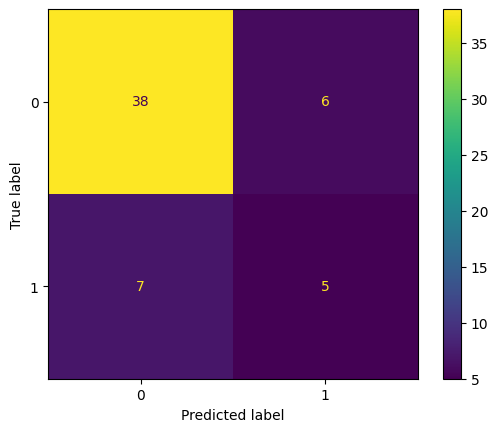

In [21]:
ConfusionMatrixDisplay.from_predictions(y_depr_dev, y_depr_pred)
plt.show()

In [73]:
def compare(pipe_old, pipe_new):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    roc1 = cross_val_score(pipe_old, X_train, y_depr_train, cv=cv, scoring='roc_auc')
    roc2 = cross_val_score(pipe_new, X_train, y_depr_train, cv=cv, scoring='roc_auc')

    print("Old train ROC AUC:", roc1.mean(), "+/-", roc1.std())
    print("New train ROC AUC:", roc2.mean(), "+/-", roc2.std())

    pipe_old.fit(X_train, y_depr_train)
    pipe_new.fit(X_train, y_depr_train)

    old_pred, old_thr, old_best_j = evaluate_with_J_threshold(pipe_old, X_dev, y_depr_dev)
    new_pred, new_thr, new_best_j = evaluate_with_J_threshold(pipe_new, X_dev, y_depr_dev)

    print("Old dev J statistic:", old_best_j, "at threshold", old_thr)
    print("New dev J statistic:", new_best_j, "at threshold", new_thr)

    print("\nOld classification report:")
    print(classification_report(y_depr_dev, old_pred))

    print("\nNew classification report:")
    print(classification_report(y_depr_dev, new_pred))

    # plot confusion matrices in one figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ConfusionMatrixDisplay.from_predictions(y_depr_dev, old_pred, ax=axes[0])
    axes[0].set_title("Old")
    ConfusionMatrixDisplay.from_predictions(y_depr_dev, new_pred, ax=axes[1])
    axes[1].set_title("New")
    plt.show()

In [50]:
# experiment with a different tokenizer

from baseline import get_wordnet_pos


NEGATIONS = {"no","not","never","n't"}

def new_tokenizer(text):
    if not isinstance(text, str): return []

    txt = text.lower()
    txt = re.sub(r"n['’]t\b", " not", txt)  # don't -> do not
    token_pattern = re.compile(r"[a-z][a-z'-]{1,}") 
    words = token_pattern.findall(txt)
    if not words: return []
    pos_tags = pos_tag(words)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    out = []
    flip = False
    for w in lemmatized_words:
        if w in NEGATIONS:
            out.append("not") 
            flip = True
            continue
        if flip and len(w) > 2:
            out.append("not_" + w)
            flip = False
        else:
            out.append(w)
    return out

def get_pipeline_tkn(tokenizer):
    vectorizer = TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1, 2), min_df=2, token_pattern=None)
    undersampler = RandomUnderSampler(random_state=42)
    lr = LogisticRegression(**best_params, random_state=42)
    return make_pipeline(vectorizer, undersampler, lr)

Old train ROC AUC: 0.704212454212454 +/- 0.02185188558532944
New train ROC AUC: 0.7204415954415956 +/- 0.011520475257614933
Old dev J statistic: 0.28030303030303033 at threshold 0.5371366726029445
New dev J statistic: 0.33333333333333337 at threshold 0.535513860377623

Old classification report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        44
           1       0.45      0.42      0.43        12

    accuracy                           0.77        56
   macro avg       0.65      0.64      0.64        56
weighted avg       0.76      0.77      0.76        56


New classification report:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80        44
           1       0.39      0.58      0.47        12

    accuracy                           0.71        56
   macro avg       0.63      0.67      0.64        56
weighted avg       0.77      0.71      0.73        56



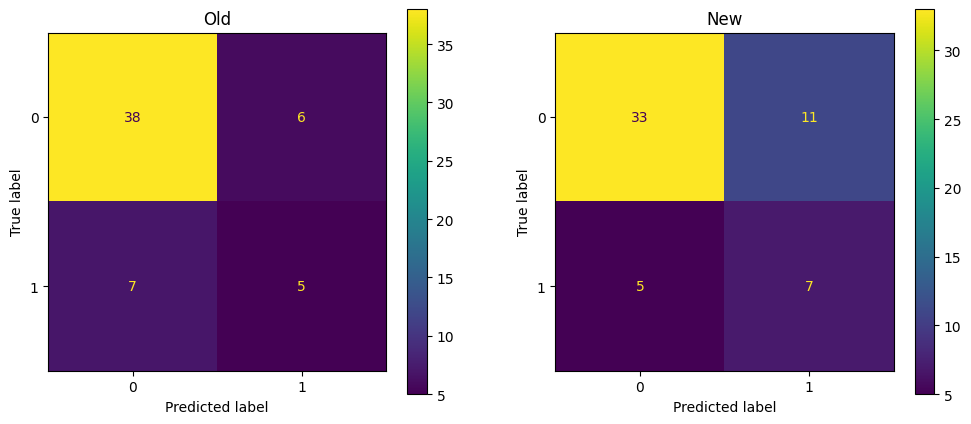

In [ ]:
pipe_old = get_pipeline_tkn(nltk_preprocess)
pipe_new = get_pipeline_tkn(new_tokenizer)

compare(pipe_old, pipe_new)

Old train ROC AUC: 0.704212454212454 +/- 0.02185188558532944
New train ROC AUC: 0.702024827024827 +/- 0.03808139441351249
Old dev J statistic: 0.28030303030303033 at threshold 0.5371366726029445
New dev J statistic: 0.3181818181818182 at threshold 0.5337043407562205

Old classification report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        44
           1       0.45      0.42      0.43        12

    accuracy                           0.77        56
   macro avg       0.65      0.64      0.64        56
weighted avg       0.76      0.77      0.76        56


New classification report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        44
           1       0.43      0.50      0.46        12

    accuracy                           0.75        56
   macro avg       0.64      0.66      0.65        56
weighted avg       0.77      0.75      0.76        56



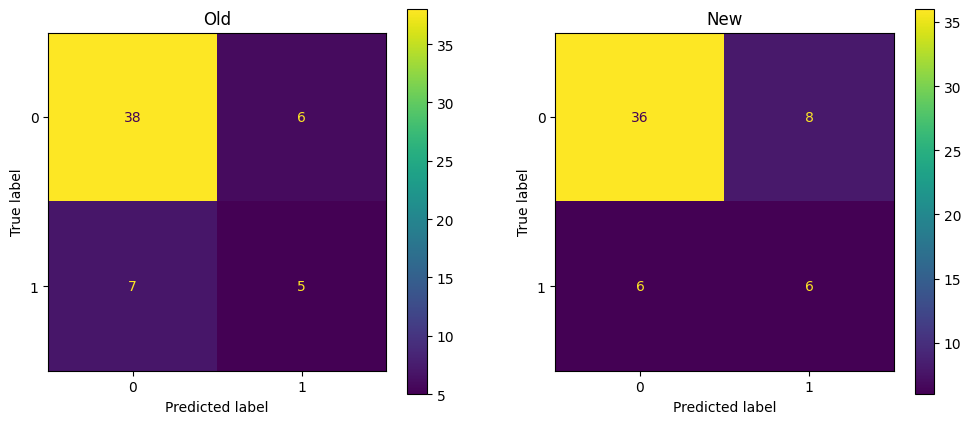

In [ ]:
# --- ABLATION STUDY 1: NO LEMMATIZATION ---

def nltk_preprocess_no_lemmatization(text):
    # make sure we get useful tokens
    token_pattern = re.compile(r"(?u)\b[^\W\d_]{3,}\b")  # at least 3 letters, letters only, unicode-aware
    txt = "" if not isinstance(text, str) else text.lower()
    words = token_pattern.findall(txt)
    return words

pipe_new = get_pipeline_tkn(nltk_preprocess_no_lemmatization)

compare(pipe_old, pipe_new)

Old train ROC AUC: 0.704212454212454 +/- 0.02185188558532944
New train ROC AUC: 0.6939865689865691 +/- 0.013965548968056034
Old dev J statistic: 0.28030303030303033 at threshold 0.5371366726029445
New dev J statistic: 0.28787878787878785 at threshold 0.23853822870911265

Old classification report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        44
           1       0.45      0.42      0.43        12

    accuracy                           0.77        56
   macro avg       0.65      0.64      0.64        56
weighted avg       0.76      0.77      0.76        56


New classification report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        44
           1       0.67      0.33      0.44        12

    accuracy                           0.82        56
   macro avg       0.75      0.64      0.67        56
weighted avg       0.80      0.82      0.80        56



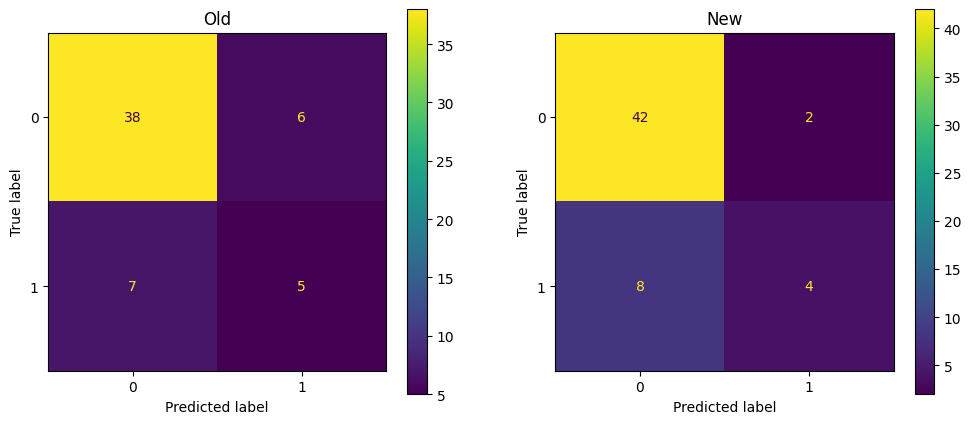

In [ ]:
# --- ABLATION STUDY 2: NO UNDER-SAMPLING ---

def get_pipeline_no_undersampling():
    vectorizer = TfidfVectorizer(tokenizer=nltk_preprocess, ngram_range=(1, 2), min_df=2, token_pattern=None)
    lr = LogisticRegression(**best_params, random_state=42)
    return make_pipeline(vectorizer, lr)

pipe_new = get_pipeline_no_undersampling()

compare(pipe_old, pipe_new)

Old train ROC AUC: 0.704212454212454 +/- 0.02185188558532944
New train ROC AUC: 0.7182539682539684 +/- 0.022853376379855826
Old dev J statistic: 0.28030303030303033 at threshold 0.5371366726029445
New dev J statistic: 0.34090909090909094 at threshold 0.5453992594617856

Old classification report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        44
           1       0.45      0.42      0.43        12

    accuracy                           0.77        56
   macro avg       0.65      0.64      0.64        56
weighted avg       0.76      0.77      0.76        56


New classification report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        44
           1       0.46      0.50      0.48        12

    accuracy                           0.77        56
   macro avg       0.66      0.67      0.67        56
weighted avg       0.77      0.77      0.77        56



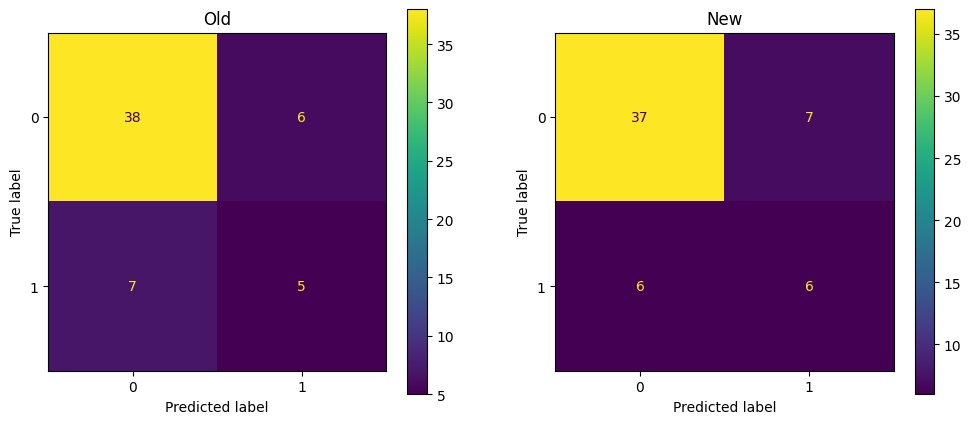

In [ ]:
# --- ABLATION STUDY 3: NO PRE-PROCESSING ---

def identity_tokenizer(text):
    if not isinstance(text, str): return []
    return text.split()

pipe_new = get_pipeline_tkn(identity_tokenizer)

compare(pipe_old, pipe_new)

In [ ]:
# experiment with NB-weighting

import scipy.sparse as sp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

# ---- NB-weight transformer (log-count ratio) ----
class NBWeight(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=1.0):
        self.alpha = float(alpha)
        self.r_ = None

    def fit(self, X, y):
        X = sp.csr_matrix(X)
        y = np.asarray(y)
        pos = (y == 1)
        neg = (y == 0)
        if pos.sum() == 0 or neg.sum() == 0:
            raise ValueError("Both classes must be present to compute NB ratios.")
        n_pos = X[pos].sum(axis=0)   # 1 x V
        n_neg = X[neg].sum(axis=0)   # 1 x V
        r = np.log((n_pos + self.alpha) / (n_neg + self.alpha))
        self.r_ = np.asarray(r).ravel()
        return self

    def transform(self, X):
        if self.r_ is None:
            raise RuntimeError("NBWeight is not fitted yet.")
        X = sp.csr_matrix(X)
        return X.multiply(self.r_)
    
def get_nb_pipeline(model_params):
    vectorizer = CountVectorizer(tokenizer=nltk_preprocess, 
                                   ngram_range=(1, 2), 
                                   min_df=2, 
                                   token_pattern=None, 
                                   binary=True)
    undersampler = RandomUnderSampler(random_state=42)
    nb_weight = NBWeight(alpha=1.0)
    lr = LogisticRegression(**model_params, random_state=42)
    return make_pipeline(vectorizer, undersampler, nb_weight, lr) 

In [67]:
# hyperparameter tuning for the NB-weighted model
from sklearn.model_selection import GridSearchCV


grid_params = {
    'logisticregression__solver': ['liblinear'],
    'logisticregression__C': [0.1, 1, 5, 10],
    'nbweight__alpha': [0.5, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
sv=GridSearchCV(
    estimator=get_nb_pipeline({}),
    param_grid=grid_params,
    scoring='roc_auc',
    cv=cv,
    verbose=2
)

sv.fit(X_train, y_depr_train)
print("Best parameters:", sv.best_params_)
print("Best cross-validation ROC AUC:", sv.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END logisticregression__C=0.1, logisticregression__solver=liblinear, nbweight__alpha=0.5; total time=   3.0s
[CV] END logisticregression__C=0.1, logisticregression__solver=liblinear, nbweight__alpha=0.5; total time=   2.9s
[CV] END logisticregression__C=0.1, logisticregression__solver=liblinear, nbweight__alpha=0.5; total time=   2.9s
[CV] END logisticregression__C=0.1, logisticregression__solver=liblinear, nbweight__alpha=1.0; total time=   3.0s
[CV] END logisticregression__C=0.1, logisticregression__solver=liblinear, nbweight__alpha=1.0; total time=   2.9s
[CV] END logisticregression__C=0.1, logisticregression__solver=liblinear, nbweight__alpha=1.0; total time=   2.9s
[CV] END logisticregression__C=0.1, logisticregression__solver=liblinear, nbweight__alpha=2.0; total time=   3.1s
[CV] END logisticregression__C=0.1, logisticregression__solver=liblinear, nbweight__alpha=2.0; total time=   2.9s
[CV] END logisticregression

Old train ROC AUC: 0.704212454212454 +/- 0.02185188558532944
New train ROC AUC: 0.7689763939763941 +/- 0.057763641198892615
Old dev J statistic: 0.28030303030303033 at threshold 0.5371366726029445
New dev J statistic: 0.30303030303030304 at threshold 0.5288013095742155

Old classification report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        44
           1       0.45      0.42      0.43        12

    accuracy                           0.77        56
   macro avg       0.65      0.64      0.64        56
weighted avg       0.76      0.77      0.76        56


New classification report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        44
           1       0.50      0.42      0.45        12

    accuracy                           0.79        56
   macro avg       0.67      0.65      0.66        56
weighted avg       0.77      0.79      0.78        56



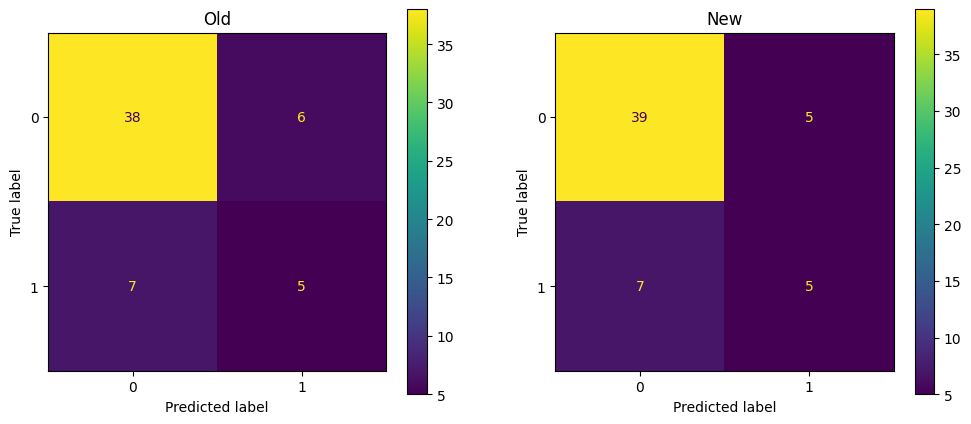

In [76]:
nb_pipe = sv.best_estimator_
compare(pipe_old, nb_pipe)

In [77]:
# interpretability analysis

import shap

features = nb_pipe.named_steps['countvectorizer']
classifier = nb_pipe.named_steps['logisticregression']

feature_names = features.get_feature_names_out()

print("n_features:", len(feature_names))
print("feature names:", feature_names[:20])

n_features: 20229
feature names: ['ability' 'able' 'able and' 'able come' 'able communicate' 'able control'
 'able deal' 'able find' 'able free' 'able get' 'able handle' 'able have'
 'able help' 'able just' 'able like' 'able listen' 'able maintain'
 'able make' 'able more' 'able pay']


In [79]:
X_train_transformed = features.transform(X_train)
X_dev_transformed = features.transform(X_dev)

masker = shap.maskers.Independent(X_train_transformed)
explainer = shap.LinearExplainer(
    model=classifier,
    masker=masker
)

shap_values = explainer(X_dev_transformed)

In [91]:
np.shape(shap_values)

(56, 20229)

/var/folders/27/ck8fkqh11018m9kgt4qrygg40000gn/T/ipykernel_75535/156031965.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_dev_transformed, feature_names=feature_names)


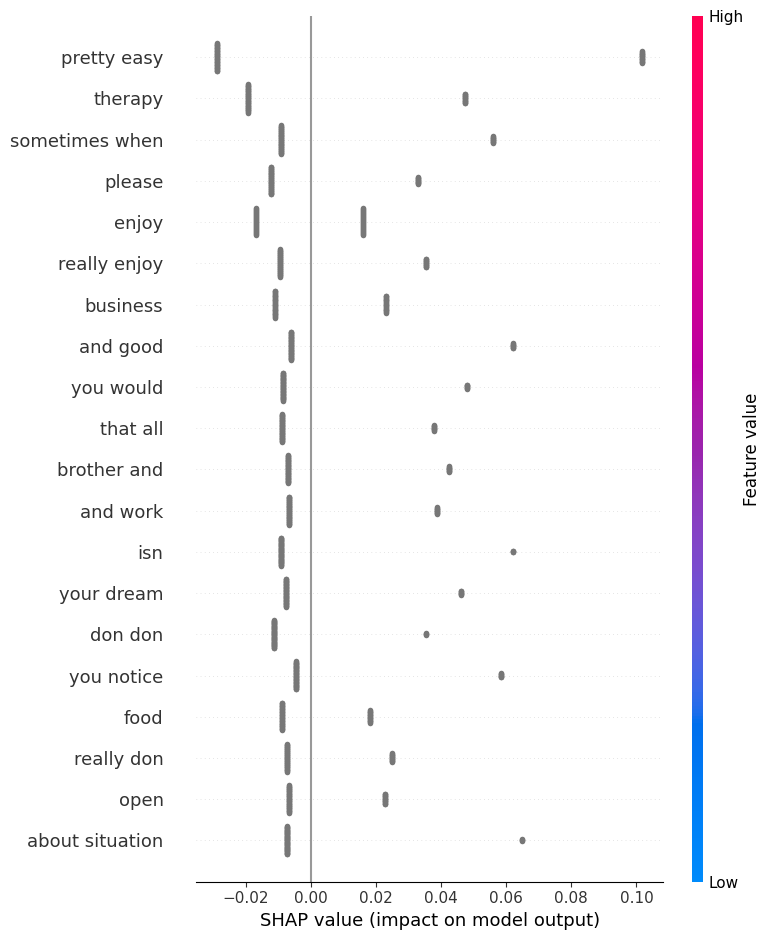

In [95]:
shap.summary_plot(shap_values, features=X_dev_transformed, feature_names=feature_names)